In [1]:
# imports
import keras, tensorflow as tf
import pandas as pd,numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import config
from data import get_data,DataGenerator,start_video_eval,get_class_data
import os
import cv2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import MaxNorm
from keras.optimizers import Adam
from keras.layers import Conv2D,BatchNormalization
from keras.layers import MaxPool2D, MaxPooling2D,Input,Concatenate
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Model



2023-09-26 15:09:19.931014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 15:09:20.992608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# setting gpu memory for efficient training 
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*3.5)])


2023-09-26 12:04:10.118371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 12:04:14.557665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 12:04:14.558364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Downloading the dataset 

In [3]:
# # for downloading dataset

# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="xEsIaDiMVG9KN7OLrIfS")
# project = rf.workspace("roboflow-58fyf").project("rock-paper-scissors-sxsw")
# dataset = project.version(12).download("retinanet")


In [3]:
# load the training dataset
def get_datagen(dataset=config.DATASET_DIR,has_boxes=2):
    gen = []
    for i in ('train','valid','test'):
        f_name,box,labels = get_data(i,dataset=dataset)
        print(f_name.shape,box.shape,labels.shape)
        d_gen = DataGenerator(f_name,box,labels,i,config.BATCH_SIZE,has_boxes = has_boxes,dataset=dataset)
        gen.append(d_gen)
    return gen


In [4]:
def get_history(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

(12090,) (12090, 4) (12090, 3)
(669,) (669, 4) (669, 3)
(351,) (351, 4) (351, 3)
(224, 224, 3)
16
[['Paper']]
[0.071875, 0.5046875, 0.3859375, 0.68125]


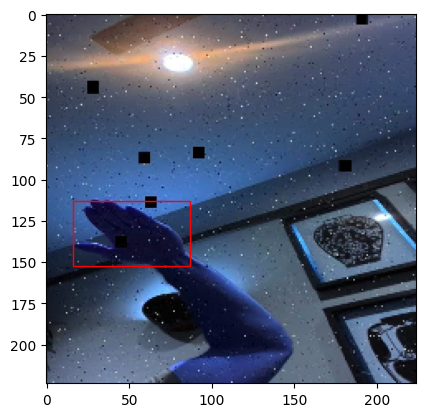

(224, 224, 3)
16
[['Scissors']]
[0.0, 0.246875, 0.39375, 1.0]


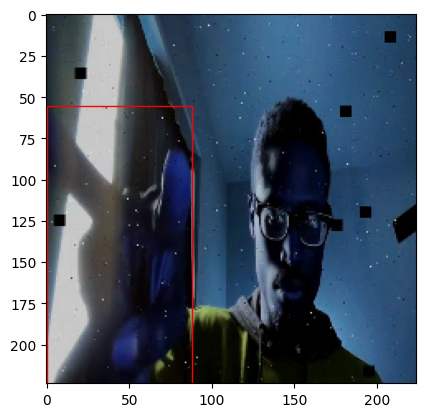

(224, 224, 3)
16
[['Paper']]
[0.4140625, 0.2984375, 0.7484375, 1.0]


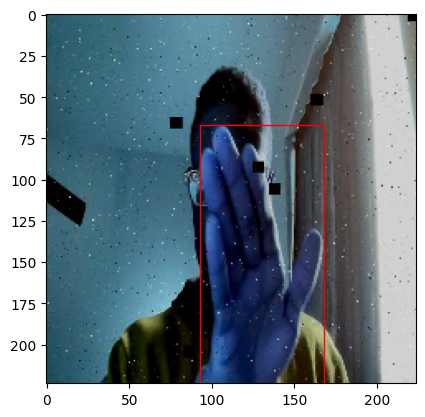

(224, 224, 3)
16
[[None]]
[0.0, 0.0, 0.0, 0.0]


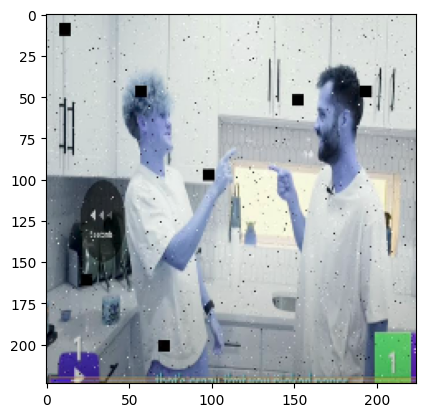

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# verifying whether the data generator works correctly
d_gen,_,__ = get_datagen(has_boxes=0)
i,u = d_gen.__getitem__(0)
num = 0
while 1:
    im = (i[num]*255).astype(int)
    print(im.shape)

   
    print(len(i))
    # Create figure and axes
    fig, ax = plt.subplots()
    h,w,_ = im.shape

    # Display the image
    ax.imshow(im)
    with open('ohencoder.pickle','rb') as f:
        import pickle 
        ohe = pickle.load(f)
    print(ohe.inverse_transform(u['class_label'].iloc[num].to_numpy().reshape(-1,3)))

    box = list(u['bounding_box'].iloc[num,:])
    print(box)
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0]*224, box[1]*224), (box[2]-box[0])*224, (box[3]-box[1])*224, linewidth=1, edgecolor='r', facecolor='none')
    # Add the rect to the Axes
    ax.add_patch(rect)

    plt.show()
    num += 1
    if 'q' == input():
        break

# MODEL BUILDING

In [ ]:

# model 1 only classifies images 
# works very well on isolated images but isolating 
# a object is a challenging task won't work practically 
# with complex background and noise 
def get_model_1():
    # sequential stacks layer into a linear model
    model = Sequential()

    # conv2d with a convolutional kernel of size 5x5 64 filters represents how many patterns can be learned
    model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu',input_shape=(224,224,3)))
    # batch normalization scales the data to appropriate terms
    # Used here to avoid loss exploding, took me a complete Sunday to figure this out
    model.add(BatchNormalization(axis=3))
    # again convolution (trying to mimics vgg net)
    model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'))
    
    # max pool takes the max of 2x2 pixels to form other filters, the data effectively is halved
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization(axis=3))
    # dropout force the network to learn actual patterns and not just memorize the data
    model.add(Dropout(0.5))

    # repeating same set of layers 2 times
    model.add(Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.5))

    # flatten the 3D tensor
    model.add(Flatten())

    # dense layer are just nor neurons, relu is used extensively throughout the cnn to prevent negative numbers 
    model.add(Dense(256, activation = "relu")) #Fully connected layer
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # adding another dense layer just to create more depth
    model.add(Dense(60, activation = "relu")) #Fully connected layer
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # 3 output for rock,paper,scissors each 
    model.add(Dense(3, activation = "softmax")) #Classification layer or output layer

    # compile with adam - derivided from SGD
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def get_model_2():
    model = Sequential()
    # tail of model 2 is same as model 1
    model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu',input_shape=(224,224,3)))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.25))

    flatten = model.output
    flatten = Flatten()(flatten)

    # here we have 2 branches for the model one for 
    # prob that object exists prob head simple fcc nn
    probHead = Dense(128, activation="relu")(flatten)
    probHead = Dense(64, activation="relu")(probHead)
    probHead = BatchNormalization()(probHead)
    probHead = Dropout(0.25)(probHead)
    probHead = Dense(32, activation="relu")(probHead)
    probHead = Dense(1, activation="sigmoid",
        name="prob")(probHead)
    
    # constructed a second fully-connected layer head, this one to predict
    # the class label
    softmaxHead = Dense(256, activation="relu")(flatten)

    softmaxHead = Dropout(0.5)(softmaxHead)
    softmaxHead = BatchNormalization()(softmaxHead)
    softmaxHead = Dense(60, activation="relu")(softmaxHead)
    softmaxHead = BatchNormalization()(softmaxHead)
    softmaxHead = Dropout(0.5)(softmaxHead)
    softmaxHead = Dense(3, activation="softmax",
        name="class_label")(softmaxHead)

    # compiling models
    model = Model(
        inputs=model.input,
        outputs=(probHead, softmaxHead))

    losses = {
        "class_label": "categorical_crossentropy",
        "prob": "binary_crossentropy",
    }
    # define a dictionary that specifies the weights per loss (both the
    # class label and bounding box outputs will receive equal weight)
    lossWeights = {
        "class_label": 2.0,
        "prob": 1.0
    }
    # initialize the optimizer, compile the model, and show the model
    # summary
    model.compile(optimizer="adam", loss=losses, loss_weights=lossWeights, metrics=['accuracy'])
    return model



In [6]:
# classification model for predicting classes on cropped objects 
# class label accuracy is bad so I won't consider this
model = get_model_2()
model.summary()

train_gen, valid_gen, test_gen = get_datagen(dataset ="/home/onu/ml/Rock-Paper-Scissors-SXSW-12", has_boxes = 1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
history = model.fit(train_gen,validation_data=valid_gen,epochs = 50,batch_size=config.BATCH_SIZE,callbacks=[es])


scores = model.evaluate(test_gen, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

2023-09-26 12:04:15.665072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 12:04:15.665997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 12:04:15.666713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 220, 220, 64)         4864      ['conv2d_input[0][0]']        
                                                                                                  
 batch_normalization (Batch  (None, 220, 220, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 216, 216, 64)         102464    ['batch_normalization[0][0

2023-09-26 12:05:13.506867: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-09-26 12:05:15.746808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-26 12:05:19.294764: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-26 12:05:21.911225: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-26 12:0

756/756 [==============================] - 453s 556ms/step - loss: 1.5304 - prob_loss: 0.6516 - class_label_loss: 0.8789 - prob_accuracy: 0.6385 - class_label_accuracy: 0.3417 - val_loss: 1.3540 - val_prob_loss: 0.6608 - val_class_label_loss: 0.6932 - val_prob_accuracy: 0.6487 - val_class_label_accuracy: 0.4021
Epoch 2/50
756/756 [==============================] - 403s 532ms/step - loss: 1.3390 - prob_loss: 0.6153 - class_label_loss: 0.7237 - prob_accuracy: 0.6741 - class_label_accuracy: 0.3203 - val_loss: 1.3871 - val_prob_loss: 0.7064 - val_class_label_loss: 0.6807 - val_prob_accuracy: 0.6831 - val_class_label_accuracy: 0.2197
Epoch 3/50
756/756 [==============================] - 402s 532ms/step - loss: 1.3084 - prob_loss: 0.5966 - class_label_loss: 0.7118 - prob_accuracy: 0.6907 - class_label_accuracy: 0.3156 - val_loss: 1.2956 - val_prob_loss: 0.6110 - val_class_label_loss: 0.6845 - val_prob_accuracy: 0.6607 - val_class_label_accuracy: 0.2362
Epoch 4/50
756/756 [===================

KeyError: 'accuracy'

dict_keys(['loss', 'prob_loss', 'class_label_loss', 'prob_accuracy', 'class_label_accuracy', 'val_loss', 'val_prob_loss', 'val_class_label_loss', 'val_prob_accuracy', 'val_class_label_accuracy'])


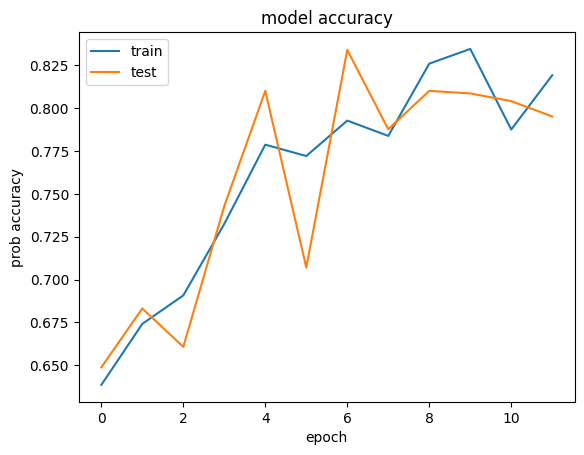

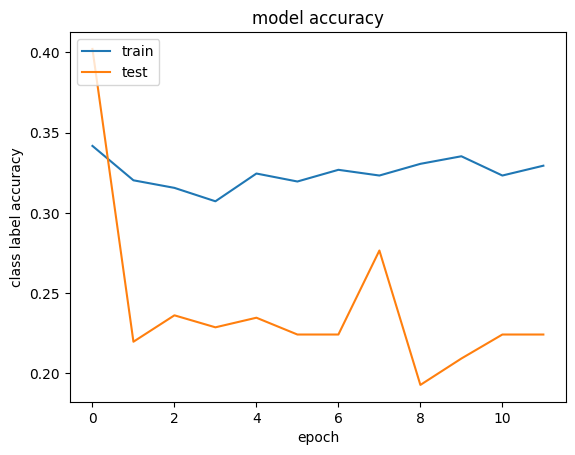

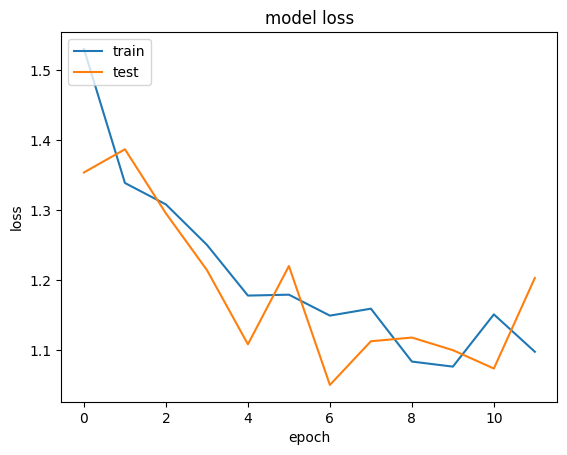

In [11]:
# above error was encountered because I was using get_history function on the above 
# get_history expects there to be one output but model 2 has 2 outputs prob and 
# class labels I will write custom code for ploting these
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['prob_accuracy'])
plt.plot(history.history['val_prob_accuracy'])
plt.title('model accuracy')
plt.ylabel('prob accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['class_label_accuracy'])
plt.plot(history.history['val_class_label_accuracy'])
plt.title('model accuracy')
plt.ylabel('class label accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Class label accuracy isn't fit to use it as a classifier even in Region Proposal aided network model 2 didn't work on this dataset 

In [6]:
# getting data for only classification based learning 
# the database used is different from config.DATBASE_DIR this dataset 
# is the multiclass classification dataset from Rock-Paper-Scissors-SXSW-12 
# hence it only contains isolated object photo 
# I don't think it will perform well for objects far from camera or with complex background 
t_gen = get_class_data('train')
v_gen = get_class_data('valid')

model = get_model_1()
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
history = model.fit(t_gen,validation_data=v_gen,epochs = 50,batch_size=config.BATCH_SIZE,callbacks=[es])


(None, 224, 224, 3) <dtype: 'float32'>
(None, 3) <dtype: 'float32'>
Epoch 1/50


2023-09-25 22:52:15.023919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-09-25 22:52:16.727276: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-25 22:52:19.559626: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-25 22:52:20.158460: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to a

72/72 [==============================] - 86s 759ms/step - loss: 1.4645 - accuracy: 0.4702 - val_loss: 1.9131 - val_accuracy: 0.3669
Epoch 2/50
72/72 [==============================] - 37s 520ms/step - loss: 1.0494 - accuracy: 0.5937 - val_loss: 1.0551 - val_accuracy: 0.5266
Epoch 3/50
72/72 [==============================] - 37s 520ms/step - loss: 0.8875 - accuracy: 0.6261 - val_loss: 1.4649 - val_accuracy: 0.3846
Epoch 4/50
72/72 [==============================] - 38s 521ms/step - loss: 0.6413 - accuracy: 0.7356 - val_loss: 1.3766 - val_accuracy: 0.4260
Epoch 5/50
72/72 [==============================] - 37s 520ms/step - loss: 0.5595 - accuracy: 0.7741 - val_loss: 0.9354 - val_accuracy: 0.5592
Epoch 6/50
72/72 [==============================] - 37s 521ms/step - loss: 0.4211 - accuracy: 0.8336 - val_loss: 0.7563 - val_accuracy: 0.7130
Epoch 7/50
72/72 [==============================] - 37s 520ms/step - loss: 0.3477 - accuracy: 0.8678 - val_loss: 1.0312 - val_accuracy: 0.6953
Epoch 8/50

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


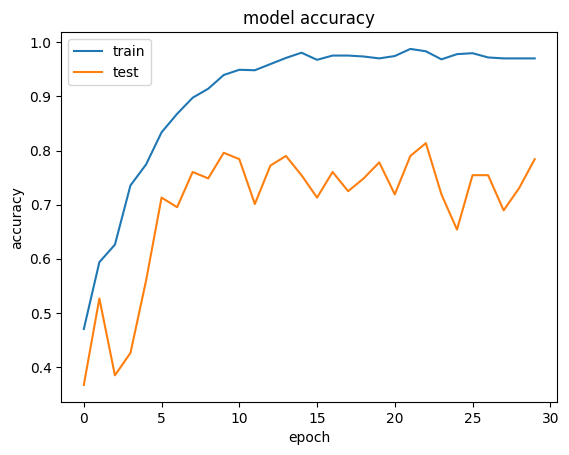

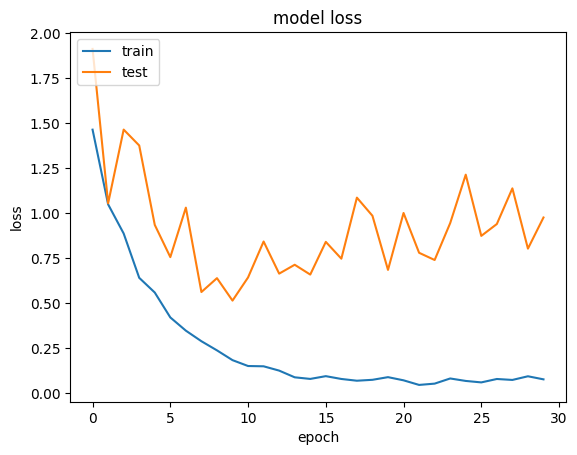

In [14]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
model.save("class_iso_final.keras")
# saving the above model it performed well on isolated images

In [12]:
t_gen = get_class_data('test')
model.evaluate(t_gen)
# 77% accuracy on test set 

12/12 [==============================] - 5s 428ms/step - loss: 1.0422 - accuracy: 0.7766


[1.0421611070632935, 0.7765957713127136]

In [ ]:
# model copying the vgg architecture unfortunately did not do well on this dataset idk why
# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in

# define model input
visible = Input(shape=(224, 224, 3))
# original model had 4 sets of vgg blocks i will use 5 for better fitting 
# add vgg module
layer = vgg_block(visible, 64, 2)
# add vgg module
layer = vgg_block(layer, 128, 2)
# add vgg module
layer = vgg_block(layer, 256, 4)

layer = vgg_block(layer, 512, 4)

layer = vgg_block(layer, 512, 4)

flatten = Flatten()(layer)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(3, activation="softmax",
	name="class_label")(softmaxHead)


# prob that object exists prob head simple fcc nn
probHead = Dense(128, activation="relu")(flatten)
probHead = Dense(64, activation="relu")(probHead)
probHead = BatchNormalization()(probHead)
probHead = Dropout(0.25)(probHead)
probHead = Dense(32, activation="relu")(probHead)
probHead = Dense(1, activation="sigmoid",
	name="prob")(probHead)
    

losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
    "prob":"binary_crossentropy",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 2.0,
	"bounding_box": 1.0,
    "prob":1.0
}
# initialize the optimizer, compile the model, and show the model
# summary

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model_bound = Model(
	inputs=visible,
	outputs=(probHead,bboxHead, softmaxHead))
opt = Adam(lr=0.001)
model_bound.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)

model_bound.summary()

k = get_datagen(has_boxes=0)
train, val, test = k[0],k[1],k[2]


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
hist = model_bound.fit(train,validation_data=val,epochs = 50,batch_size=config.BATCH_SIZE,callbacks=[es])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                         

2023-09-25 20:21:30.701621: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-25 20:21:31.584255: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


756/756 [==============================] - 122s 156ms/step - loss: 1.1808 - prob_loss: 0.3106 - bounding_box_loss: 0.0547 - class_label_loss: 0.8155 - prob_accuracy: 0.8645 - bounding_box_accuracy: 0.5055 - class_label_accuracy: 0.3702 - val_loss: 1.3998 - val_prob_loss: 0.6563 - val_bounding_box_loss: 0.0415 - val_class_label_loss: 0.7020 - val_prob_accuracy: 0.8087 - val_bounding_box_accuracy: 0.5800 - val_class_label_accuracy: 0.2242
Epoch 2/50
756/756 [==============================] - 106s 140ms/step - loss: 1.0659 - prob_loss: 0.1693 - bounding_box_loss: 0.0289 - class_label_loss: 0.8677 - prob_accuracy: 0.9348 - bounding_box_accuracy: 0.5396 - class_label_accuracy: 0.3246 - val_loss: 1.2470 - val_prob_loss: 0.4915 - val_bounding_box_loss: 0.0359 - val_class_label_loss: 0.7196 - val_prob_accuracy: 0.8296 - val_bounding_box_accuracy: 0.5142 - val_class_label_accuracy: 0.3931
Epoch 3/50
756/756 [==============================] - 106s 140ms/step - loss: 0.9867 - prob_loss: 0.1121 - 

In [12]:
model.evaluate(test)
model.save("bounding_box_model.keras")

22/22 [==============================] - 4s 194ms/step - loss: 1.3644 - prob_loss: 0.5831 - bounding_box_loss: 0.0204 - class_label_loss: 0.7610 - prob_accuracy: 0.9316 - bounding_box_accuracy: 0.6695 - class_label_accuracy: 0.2165


### Video input classification on both classification and detection model

In [2]:
import pickle
# for only class model
model = tf.keras.models.load_model('class_iso_final.keras')
# this model can classify the symbols okish but since it was trained on 
# isolated object images hand has to be close to camera and 
# since it wasn't given any negative examples it always predicts a class which is bad
with open('ohencoder.pickle','rb') as f:        
        ohe = pickle.load(f)
# this function starts the camera with model given to it 
# write classified class on the top 
# if box coordinates also predicted by model 
# then displays box
start_video_eval(model,ohe,has_boxes=2)

# https://drive.google.com/drive/folders/1IL2CTH-fhnBu-wpMIXjf9dFuPfe8Ksc7?usp=drive_link watch the video on this link 


2023-09-26 15:09:31.315759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 15:09:31.348448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 15:09:31.348725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
import pickle
# for class and 
model = tf.keras.models.load_model('bounding_box_model.keras')
# since my vgg clones class label loss is huge this performs really bad on camera
with open('ohencoder.pickle','rb') as f:        
        ohe = pickle.load(f)
# this function starts the camera with model given to it 
# write classified class on the top 
# if box coordinates also predicted by model 
# then displays box

# with the bounding box model the class label loss was huge 
# that is why it barely predicts classes correctly 
# bounding box is also unstable.
# training a vgg clone on this model 
start_video_eval(model,ohe,has_boxes=0)

# https://drive.google.com/drive/folders/1IL2CTH-fhnBu-wpMIXjf9dFuPfe8Ksc7?usp=drive_link watch the video on this link 


[ WARN:0@427.049] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
2023-09-26 14:12:12.596273: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-26 14:12:12.766759: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-26 14:12:12.928701: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this 